In [2]:
# import the libraries
!pip install pandas_datareader pandas --upgrade
import yfinance as yf
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')




In [ ]:
# Read the Excel file into a DataFrame
df = pd.read_excel("/content/ahluwaliaepspe.xlsx")

In [ ]:
df.isnull().sum()

Slot Date    0
EPS          0
P/E          0
dtype: int64

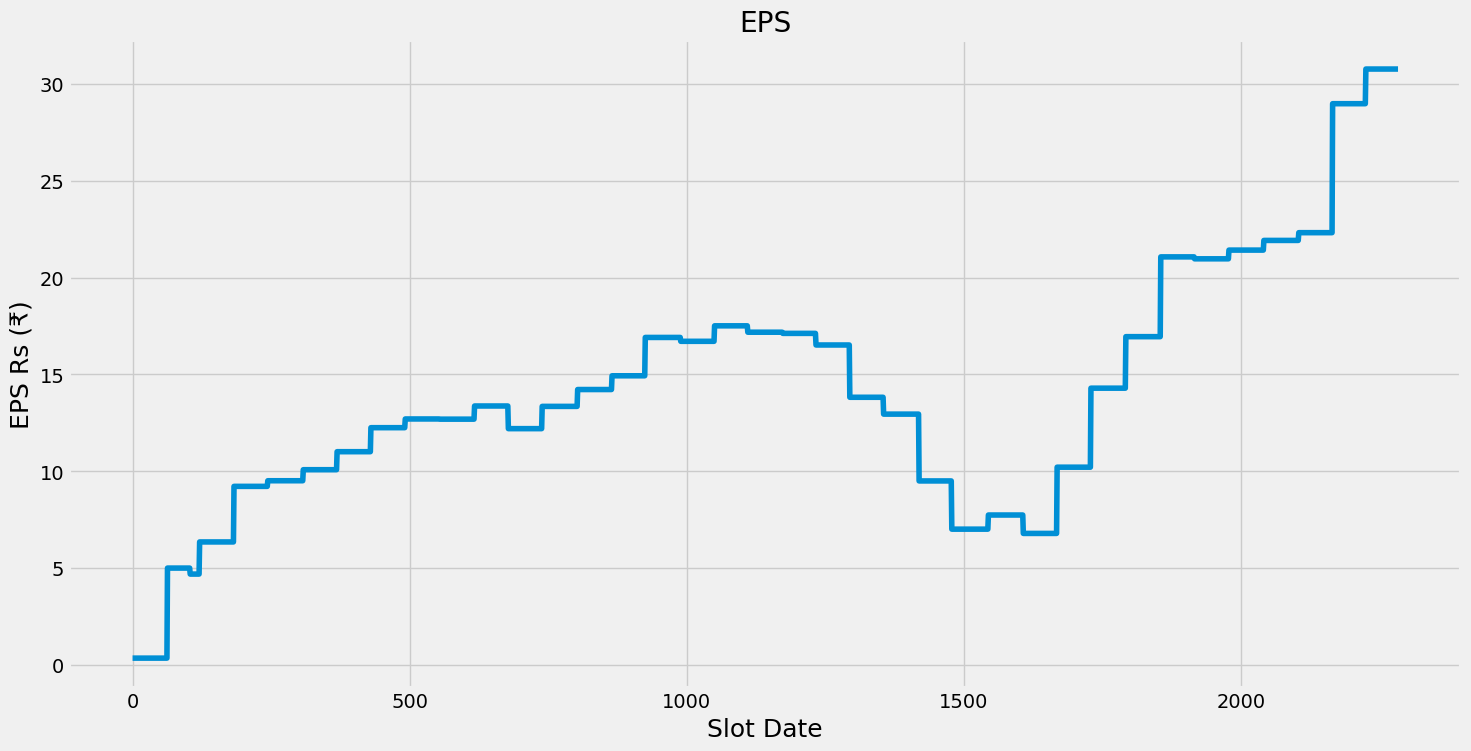

In [ ]:
plt.figure(figsize=(16,8))
plt.title ('EPS')
plt.plot(df['EPS'])
plt.xlabel('Slot Date', fontsize=18)
plt.ylabel('EPS Rs (₹)', fontsize=18)
plt.show()


In [ ]:
# create a new data frame with only the close column
data = df.filter(['EPS'])
#convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len
# Scale the data (preprocessing, normalizing/scaling the data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()
x_train, y_train =np.array(x_train), np.array(y_train)
# Reshape the data,because LSTM requires inputs to be in 3-dim(no.of samples,no.of time stamps, no.of features) and right now our data is in 2-dim
 #x_train.shape # we will only get 2-dim (rows,columns)
# now convert the array to 3-dim
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1)) #no. of rows, no.columns, closing price
x_train.shape
#Built the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=2)


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[0.0]

Epoch 1/2
1768/1768 [==============================] - 72s 39ms/step - loss: 6.3322e-04
Epoch 2/2
1768/1768 [==============================] - 50s 28ms/step - loss: 2.9630e-04


In [ ]:
#create the testing data set
#create a new array containing scaled values from index 2047 to 2507
test_data = scaled_data[training_data_len - 60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # all the values that we want our model to predict, actual test values
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  # these values are not scaled, they are the original data
# Convert the data to a numpy array
x_test = np.array(x_test)
#Reshape the data (from 2-dim to 3-dim)
x_test =np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1)) #No.of rows,no.of columns,no.of features
# get the model's predicted price values (we want predicitions based on the x_test dataset)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # we want predictions to contain the same values as our y_test data set contains
# we are unscaling the values
# get the root mean squared error (RMSE) lower value indicates a better fit
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse


15/15 [==============================] - 1s 14ms/step


0.6003715502874399

<ipython-input-9-2eb9db6e376c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


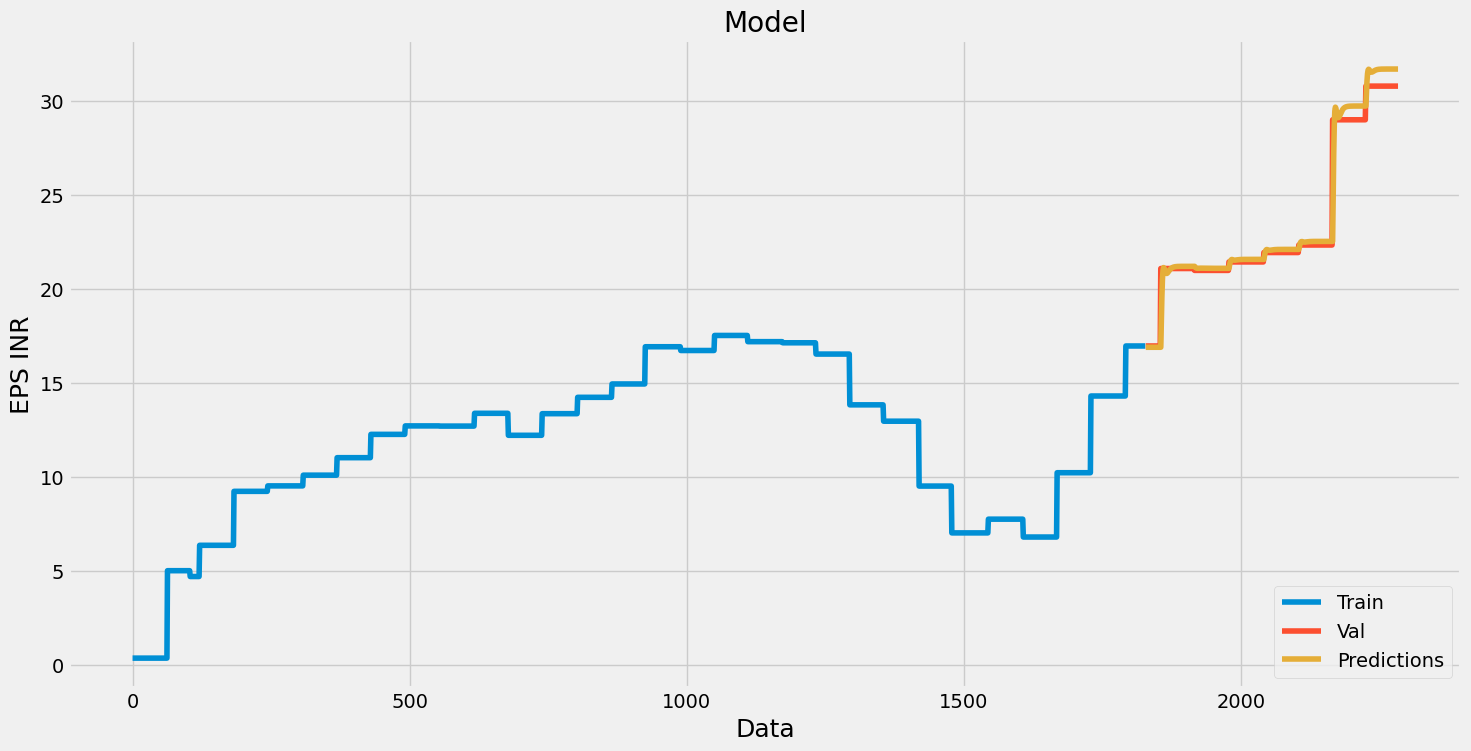

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('EPS INR', fontsize=18)
plt.plot(train['EPS'])
plt.plot(valid[['EPS', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()


In [ ]:
valid['Error Godrej'] = ((valid['Predictions'] - valid['EPS']) / valid['EPS']) * 100
valid
average = valid['Error Godrej'].mean()

# Print the average
print("Average:", average)



Average: 0.7514588420924943


<ipython-input-10-517c8a8871a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Error Godrej'] = ((valid['Predictions'] - valid['EPS']) / valid['EPS']) * 100


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2013-01-01  126.377869  130.436584  124.534409  129.878906  115.741745   58736
2013-01-02  130.452072  133.999588  130.452072  131.102707  116.832352   86274
2013-01-03  131.102707  132.295547  130.421097  131.489990  117.177475   25294
2013-01-04  130.281677  131.830795  129.816940  130.173233  116.004051   24339
2013-01-07  131.071732  131.660400  128.918442  129.553589  115.451843   15063
...                ...         ...         ...         ...         ...     ...
2023-09-14  585.549988  596.400024  579.000000  589.500000  589.500000  203057
2023-09-15  592.200012  592.200012  572.900024  578.700012  578.700012  275291
2023-09-18  584.750000  584.750000  566.000000  567.000000  567.000000  192528
2023-09-20  565.950012  566.700012  554.299988  561.400024  56

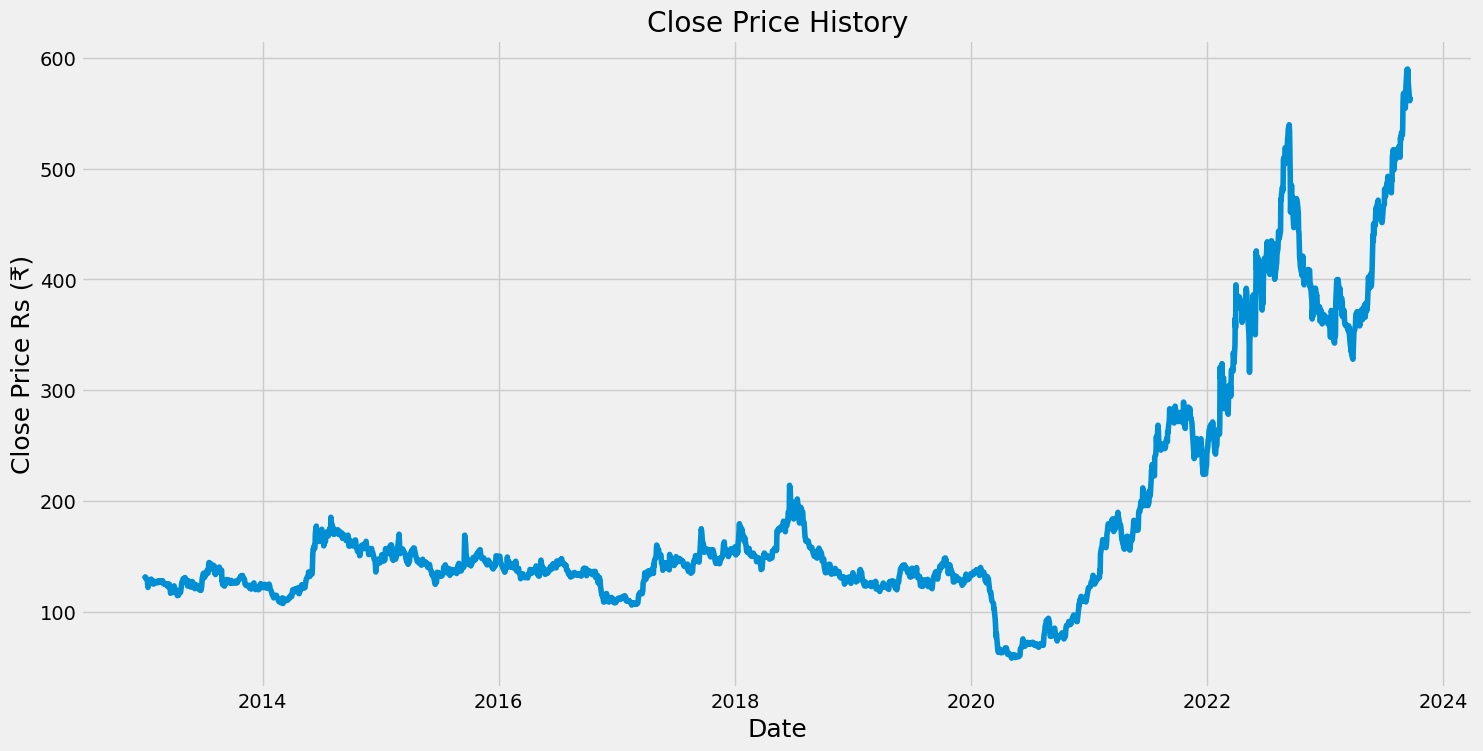

In [11]:
stock_symbol = 'MAHLIFE.NS'

# Define the date range
start_date = '2013-01-01'
end_date = '2023-09-22'

# Fetch the stock data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the data
print(df)
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title ('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rs (₹)', fontsize=18)
plt.show()



In [12]:
# create a new data frame with only the close column
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len
# Scale the data (preprocessing, normalizing/scaling the data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()
#convert the x_train and y_train to numpy array, so that we can now use them to train the model
x_train, y_train =np.array(x_train), np.array(y_train)
# Reshape the data,because LSTM requires inputs to be in 3-dim(no.of samples,no.of time stamps, no.of features) and right now our data is in 2-dim
 #x_train.shape # we will only get 2-dim (rows,columns)
# now convert the array to 3-dim
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1)) #no. of rows, no.columns, closing price
x_train.shape
#Built the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=2)



[array([0.13489391, 0.13719486, 0.13792302, 0.1354473 , 0.13428226,
       0.1343405 , 0.13302983, 0.12539874, 0.11998126, 0.12595214,
       0.13084536, 0.12962205, 0.13069972, 0.12737933, 0.13413663,
       0.13270943, 0.13215602, 0.12769971, 0.12854438, 0.12560262,
       0.12732107, 0.12938904, 0.13061235, 0.12935991, 0.12839875,
       0.12772884, 0.12979681, 0.12924342, 0.12883564, 0.12802011,
       0.13136962, 0.131224  , 0.12973856, 0.12970943, 0.12938904,
       0.13072885, 0.13113661, 0.13125312, 0.12962205, 0.13154437,
       0.12822399, 0.12918516, 0.12647642, 0.12595214, 0.12551525,
       0.12560262, 0.12467058, 0.12583564, 0.12638905, 0.12437933,
       0.12577738, 0.12467058, 0.12111718, 0.12633078, 0.125457  ,
       0.12350553, 0.12120457, 0.11794243, 0.11013659, 0.11229193])]
[0.1127288223051287]

Epoch 1/2
2057/2057 [==============================] - 37s 17ms/step - loss: 2.9630e-04
Epoch 2/2
2057/2057 [==============================] - 35s 17ms/step - loss: 1.1442

In [13]:
#create the testing data set
#create a new array containing scaled values from index 2047 to 2507
test_data = scaled_data[training_data_len - 60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # all the values that we want our model to predict, actual test values
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  # these values are not scaled, they are the original data
# Convert the data to a numpy array
x_test = np.array(x_test)
#Reshape the data (from 2-dim to 3-dim)
x_test =np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1)) #No.of rows,no.of columns,no.of features
# get the model's predicted price values (we want predicitions based on the x_test dataset)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # we want predictions to contain the same values as our y_test data set contains
# we are unscaling the values
# get the root mean squared error (RMSE) lower value indicates a better fit
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse


17/17 [==============================] - 1s 9ms/step


10.204834977647009

<ipython-input-7-e066e84d13c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


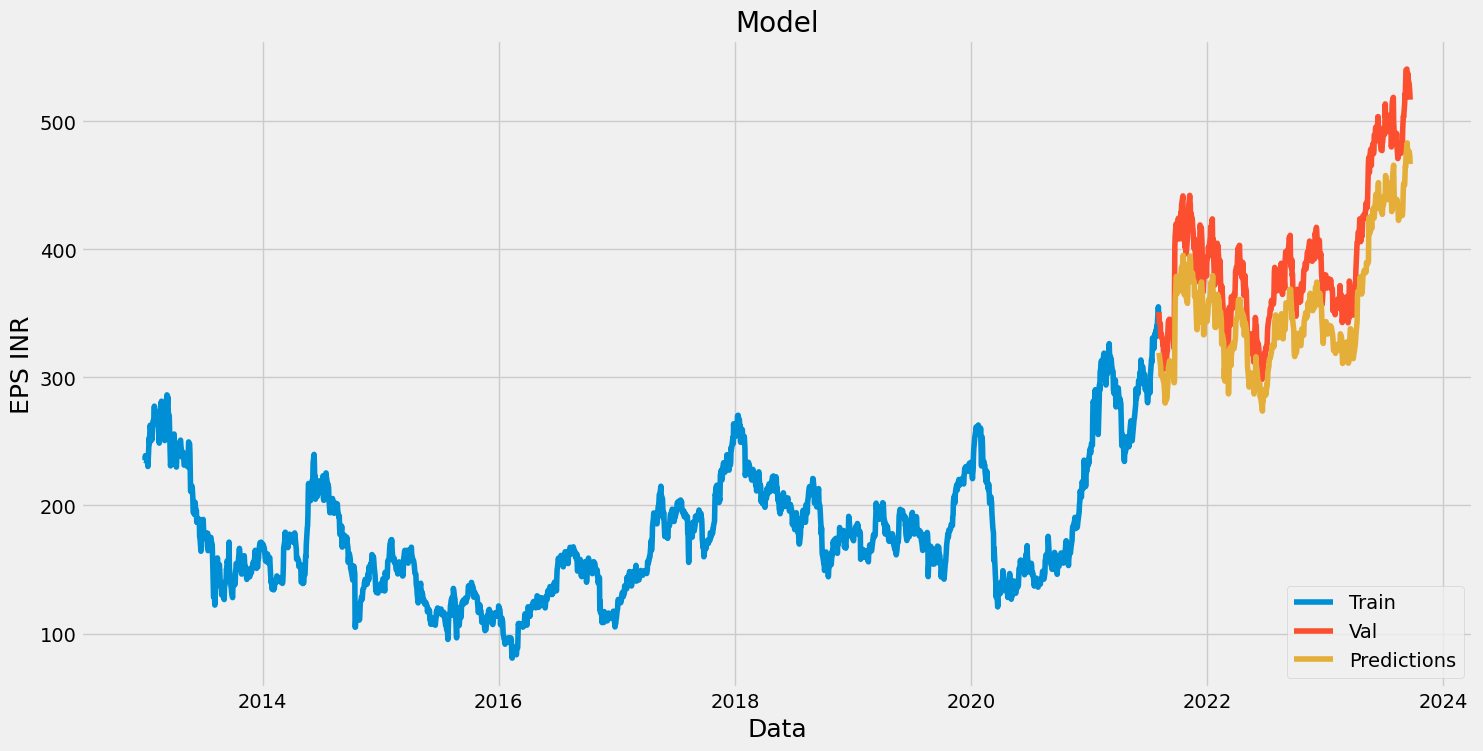

In [7]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Data', fontsize=18)
plt.ylabel('EPS INR', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()


In [14]:
valid['Error Godrej'] = ((valid['Predictions'] - valid['Close']) / valid['Close']) * 100
valid

,Close,Predictions,Error Godrej
Date,,,
2021-08-05,351.049988,319.192047,-9.075044
2021-08-06,342.799988,317.555969,-7.364066
2021-08-09,342.250000,311.508636,-8.982137
2021-08-10,334.250000,309.183594,-7.499299
2021-08-11,331.549988,304.075317,-8.286735
...,...,...,...
2023-09-14,537.349976,468.853455,-12.747097
2023-09-15,532.400024,477.454651,-10.320318
2023-09-18,529.400024,476.444824,-10.002871


In [15]:
import datetime

# Calculate the date for tomorrow
today = datetime.date.today()
tomorrow = today - datetime.timedelta(days=1)
tomorrow_str = tomorrow.strftime('%Y-%m-%d')

# Fetch the data for the next day
next_day_data = yf.download(stock_symbol, start=tomorrow_str, end=tomorrow_str)

# Extend your dataset by one day with the data for tomorrow
extended_data = pd.concat([df, next_day_data])

# Scale the extended data
extended_scaled_data = scaler.transform(extended_data[['Close']])

# Create an input sequence for the next day prediction
last_60_days = extended_scaled_data[-60:]
x_input = np.reshape(last_60_days, (1, 60, 1))

# Use the model to predict the closing price for tomorrow
predicted_closing_price = model.predict(x_input)

# Inverse transform the predicted value to get the actual closing price
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

# Print the predicted closing price for tomorrow
print("Predicted Closing Price for Tomorrow:", predicted_closing_price[0][0])


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 18ms/step
Predicted Closing Price for Tomorrow: 561.12036


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [16]:
import datetime

# Initialize a variable to store the predicted prices for the next week
predicted_prices_week = []

# Calculate the date for tomorrow
today = datetime.date.today()

# Iterate for the next 7 days to make predictions
for _ in range(7):
    # Calculate the date for the next day
    next_day = today + datetime.timedelta(days=1)
    next_day_str = next_day.strftime('%Y-%m-%d')

    # Fetch the data for the next day
    next_day_data = yf.download(stock_symbol, start=next_day_str, end=next_day_str)

    # Extend your dataset by one day with the data for the next day
    extended_data = pd.concat([df, next_day_data])

    # Scale the extended data
    extended_scaled_data = scaler.transform(extended_data[['Close']])

    # Create an input sequence for the next day prediction
    last_60_days = extended_scaled_data[-60:]
    x_input = np.reshape(last_60_days, (1, 60, 1))

    # Use the model to predict the closing price for the next day
    predicted_closing_price = model.predict(x_input)

    # Inverse transform the predicted value to get the actual closing price
    predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

    # Append the predicted closing price to the list
    predicted_prices_week.append(predicted_closing_price[0][0])

    # Update the current date for the next iteration
    today = next_day

# Print the predicted closing prices for the next week
print("Predicted Closing Prices for the Next Week:")
for i, price in enumerate(predicted_prices_week):
    print(f"Day {i+1}: {price}")


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1695580200, endDate = 1695580200")



1/1 [==============================] - 0s 24ms/step
[*********************100%%**********************]  1 of 1 completed

<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

1/1 [==============================] - 0s 24ms/step
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1695753000, endDate = 1695753000")


<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

1/1 [==============================] - 0s 26ms/step
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1695839400, endDate = 1695839400")



1/1 [==============================] - 0s 41ms/step


<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1695925800, endDate = 1695925800")



1/1 [==============================] - 0s 25ms/step


<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1696012200, endDate = 1696012200")



1/1 [==============================] - 0s 31ms/step


<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHLIFE.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1696098600, endDate = 1696098600")



1/1 [==============================] - 0s 36ms/step
Predicted Closing Prices for the Next Week:
Day 1: 564.6531982421875
Day 2: 564.6531982421875
Day 3: 564.6531982421875
Day 4: 564.6531982421875
Day 5: 564.6531982421875
Day 6: 564.6531982421875
Day 7: 564.6531982421875


<ipython-input-16-6108351a5785>:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  extended_data = pd.concat([df, next_day_data])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

In [ ]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Replace 'stock_symbol' with the actual stock symbol you want to predict
stock_symbol = 'AAPL'

# Initialize a variable to store the predicted prices for the next month
predicted_prices_month = []

# Calculate the date for tomorrow
today = datetime.date.today()

# Define the number of days in one month (approximately 30 days)
num_days_in_month = 30

# Initialize a scaler for data transformation
scaler = MinMaxScaler()

# Fetch historical data
df = yf.download(stock_symbol, start=(today - datetime.timedelta(days=num_days_in_month)).strftime('%Y-%m-%d'),
                 end=today.strftime('%Y-%m-%d'))

# Scale the historical data
scaled_data = scaler.fit_transform(df[['Close']])

# Iterate for the next month to make predictions
for _ in range(num_days_in_month):
    # Calculate the date for the next day
    next_day = today + datetime.timedelta(days=1)
    next_day_str = next_day.strftime('%Y-%m-%d')

    # Fetch the data for the next day
    next_day_data = yf.download(stock_symbol, start=next_day_str, end=next_day_str)

    # Extend your dataset by one day with the data for the next day
    extended_data = pd.concat([df, next_day_data])

    # Scale the extended data
    extended_scaled_data = scaler.transform(extended_data[['Close']])

    # Create an input sequence for the next day prediction
    last_60_days = extended_scaled_data[-60:]
    x_input = np.reshape(last_60_days, (1, 60, 1))

    # Use the model to predict the closing price for the next day
    predicted_closing_price = model.predict(x_input)

    # Inverse transform the predicted value to get the actual closing price
    predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

    # Append the predicted closing price to the list
    predicted_prices_month.append(predicted_closing_price[0][0])

    # Update the current date for the next iteration
    today = next_day

# Print the predicted closing prices for the next month
print("Predicted Closing Prices for the Next Month:")
for i, price in enumerate(predicted_prices_month):
    print(f"Day {i+1}: {price}")
